In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as nu, pandas as pds, os, math, matplotlib.pyplot as matsp, seaborn as sbsp, nltk
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')
from nltk import corpus    
from sklearn import neighbors, ensemble, linear_model, naive_bayes, neural_network,metrics, model_selection, utils
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.utils import resample
import datetime
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def SpamDataReading():
    ph=pds.read_csv("enron_spam_data.csv")
    if len(ph.columns)>2:
        ph=ph[['Message','Spam/Ham']]
    return ph
SpmData=SpamDataReading()
SpmData.head()

,Message,Spam/Ham
0,NaN,ham
1,"gary , production from the high island larger ...",ham
2,- calpine daily gas nomination 1 . doc,ham
3,fyi - see note below - already done .\nstella\...,ham
4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham


Spam/Ham
spam    17171
ham     16545
Name: count, dtype: int64


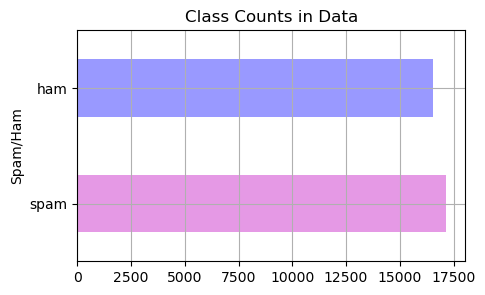

In [5]:
def EmailVIS(ph):
    trgvar='Spam/Ham'
    vctr=ph[trgvar].value_counts()
    print(vctr)
    vctr.plot(kind='barh',figsize=(5,3),title="Class Counts in Data",color=['m','b'],alpha=0.4)
    matsp.grid()
    matsp.show()
EmailVIS(SpmData)

In [6]:
def EmailFetDetails(sp):
    print("\nFeature Details Before Cleaning\n")
    print(sp.info(),"\n")
    mssp=sum(sp.isna().sum())
    if mssp>0:
        sp=sp.dropna()
        print("\nFeature Details After Cleaning\n")
        print(sp.info(),"\n")
    return sp
    
SpmData=EmailFetDetails(SpmData)
SpmData.head()


Feature Details Before Cleaning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   33664 non-null  object
 1   Spam/Ham  33716 non-null  object
dtypes: object(2)
memory usage: 526.9+ KB
None 


Feature Details After Cleaning

<class 'pandas.core.frame.DataFrame'>
Index: 33664 entries, 1 to 33715
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   33664 non-null  object
 1   Spam/Ham  33664 non-null  object
dtypes: object(2)
memory usage: 789.0+ KB
None 



,Message,Spam/Ham
1,"gary , production from the high island larger ...",ham
2,- calpine daily gas nomination 1 . doc,ham
3,fyi - see note below - already done .\nstella\...,ham
4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham
5,"jackie ,\nsince the inlet to 3 river plant is ...",ham


In [7]:
def TextCleanEmail(sp):
    SpStopsEm = list(corpus.stopwords.words('english'))
    SpCleaned=""
    for e in sp:
        if e.isalpha()==True:
            SpCleaned+=e
        if e.isalnum()==False:
            pass
        if e=="\n" or e==" " or e==":" or e==";" or e==",":
            SpCleaned+=" "
    SpSplit=SpCleaned.lower()
    TknSp=SpSplit.split()
    SpStopsEmCln=[]
    for i in TknSp:
        if i not in SpStopsEm:
            SpStopsEmCln.append(i)
    return ' '.join(SpStopsEmCln)

MsgSp=SpmData['Message'].tolist()
MsgCleaned=[]
for t in MsgSp:
    MsgCleaned.append(TextCleanEmail(t))
SpmData['Message']=MsgCleaned
SpmData.head()

,Message,Spam/Ham
1,gary production high island larger block comme...,ham
2,calpine daily gas nomination doc,ham
3,fyi see note already done stella forwarded ste...,ham
4,fyi forwarded lauri allen hou ect pm kimberly ...,ham
5,jackie since inlet river plant shut last day f...,ham


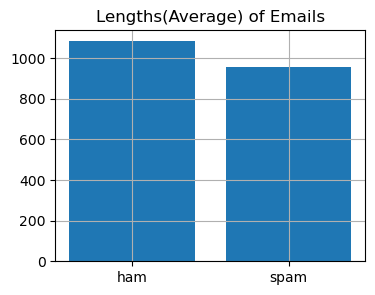

In [8]:
meanlngth=[]
SpCls=SpmData['Spam/Ham'].unique()
for x in SpCls:
    subdata=SpmData[SpmData['Spam/Ham']==x].reset_index(drop=True)
    lengths=[]
    for b in subdata['Message']:
        lengths.append(len(b))
    meanlngth.append(nu.mean(nu.array(lengths)))

matsp.figure(figsize=(4,3))
matsp.title("Lengths(Average) of Emails") 
matsp.bar(SpCls,meanlngth)
matsp.grid()
matsp.show()

In [9]:
SpmData1=SpmData.copy()
count_top=SpmData1['Spam/Ham'].value_counts().tolist()[0]
data_classes=SpmData1['Spam/Ham'].value_counts().index.tolist()

print("Class Labels Before Balancing\n")
print(SpmData1['Spam/Ham'].value_counts())

Data_EQSp=[]
for x in data_classes:
    df=SpmData1[SpmData1['Spam/Ham']==x]
    df=utils.resample(df, replace = True, n_samples = int(len(df)*(count_top/len(df))), random_state = 32)
    Data_EQSp.append(df)
SpmData1_EQ=pds.concat(Data_EQSp).reset_index(drop=True)
SpmData1_EQ1=SpmData1_EQ.copy()
print("\nClass Labels After Balancing\n")
print(SpmData1_EQ1['Spam/Ham'].value_counts())

trn_X, tst_X, trn_Y, tst_Y=model_selection.train_test_split(SpmData1_EQ1['Message'],SpmData1_EQ1['Spam/Ham'],test_size=0.25, random_state=21)

SpDtTrPart=pds.concat([trn_X,trn_Y],axis=1).reset_index(drop=True)
SpDtTsPart=pds.concat([tst_X,tst_Y],axis=1).reset_index(drop=True)
print(SpDtTrPart.shape,SpDtTsPart.shape)
print("\nTraining Class Distribution\n",SpDtTrPart['Spam/Ham'].value_counts())
print("\nTest Class Distribution\n",SpDtTsPart['Spam/Ham'].value_counts())
SpDtTrPart

Class Labels Before Balancing

Spam/Ham
spam    17171
ham     16493
Name: count, dtype: int64

Class Labels After Balancing

Spam/Ham
spam    17171
ham     17171
Name: count, dtype: int64
(25756, 2) (8586, 2)

Training Class Distribution
 Spam/Ham
ham     12908
spam    12848
Name: count, dtype: int64

Test Class Distribution
 Spam/Ham
spam    4323
ham     4263
Name: count, dtype: int64


,Message,Spam/Ham
0,craig thanks feedback elena really great think...,ham
1,westvaco brand new company added march also kn...,ham
2,sally congratulations promotion sincerely judy...,ham
3,start date hourahead hour ancillary schedules ...,spam
4,fyi kim original message frazier perry sent th...,spam
...,...,...
25751,start date hourahead hour ancillary schedules ...,spam
25752,tried calling phone rolled someone else voicem...,spam
25753,start date hourahead hour ancillary schedules ...,spam
25754,fyi kim original message frazier perry sent th...,spam


In [10]:
txt_SpDtTrPart=SpDtTrPart['Message']
txt_SpDtTsPart=SpDtTsPart['Message']
ClsTest=SpDtTsPart['Spam/Ham']
ClsTrain=SpDtTrPart['Spam/Ham']

In [39]:
vvy=[
    ensemble.RandomForestClassifier(),
    linear_model.LogisticRegression(),
    naive_bayes.BernoulliNB(),
    neighbors.KNeighborsClassifier(),
    linear_model.Perceptron()
]
print(*vvy,sep="\n")

RandomForestClassifier()
LogisticRegression()
BernoulliNB()
KNeighborsClassifier()
Perceptron()


In [30]:
SpModels=[
    ensemble.RandomForestClassifier(),
    linear_model.LogisticRegression(),
    naive_bayes.BernoulliNB(),
    neighbors.KNeighborsClassifier(),
    linear_model.Perceptron()
]
crdrmd=os.listdir(os.getcwd())
SpClfs=[
    "Random Forest",
    "Logistic Regression",
    "Naive Bayes",
    "K-Neighbors",
    "Neural Network"
]
savename=[
    'RFC.sav',
    'LR.sav',
    'NB.sav',
    'KNN.sav',
    'NN.sav'
]   

if 'RFC.sav' in crdrmd and 'LR.sav' in crdrmd and 'NB.sav' in crdrmd and 'KNN.sav' in crdrmd and 'NN.sav' in crdrmd:
    md_dr1=pickle.load(open(savename[0], 'rb'))
    md_dr2=pickle.load(open(savename[1], 'rb'))
    md_dr3=pickle.load(open(savename[2], 'rb'))
    md_dr4=pickle.load(open(savename[3], 'rb'))
    md_dr5=pickle.load(open(savename[4], 'rb'))
    SpModels=[md_dr1]  #,md_dr2,md_dr3,md_dr4, md_dr5
    print(*SpModels, sep="\n")
else:
    tune_hyp_prm=[
        [{'criterion': ['gini', 'entropy'],'max_depth':[90,100]}],
        [{"tol":[0.01,0.001,0.0001,0.00001],'C':[0.2,0.4,0.6,0.8,1.0],"max_iter":[100,200]}],
        [{"alpha":[0.2,0.4,0.6,0.8,1.0]}],
        [{"n_neighbors":[4,5,6],"algorithm":['auto','kd_tree']}],
        [{"max_iter":[500,1000],"alpha":[0.0001,0.00001,0.000001],"tol":[0.001,0.0001,0.00001]}]
    ]

    for ic in range(len(SpModels)):
        print("____________________________________________________")
        print("Tuning {} Model =>".format(SpClfs[ic]))
        print("____________________________________________________")
        t1 = datetime.datetime.now() 
        GSTuning = model_selection.GridSearchCV(SpModels[ic], tune_hyp_prm[ic], cv = 5, scoring='accuracy')
        GSTuning.fit(TrnVct, ClsTrain)
        SpModels[ic]=GSTuning.best_estimator_
        print("Optimum Parameters of {}:\n{}".format(SpClfs[ic],GSTuning.best_estimator_))
        print("____________________________________________________")
        t2 = datetime.datetime.now()
        delta = t2 - t1
        tuningtime=delta.total_seconds()
        print("Tuning Time: {} Seconds".format(tuningtime))
        print("'{}' Tuning Complete........".format(SpClfs[ic]))
        print("____________________________________________________")

    for cp in range(len(SpModels)):
        pickle.dump(SpModels[cp], open(savename[cp], 'wb'))
    print(*SpModels, sep="\n")

____________________________________________________
Tuning Random Forest Model =>
____________________________________________________
Optimum Parameters of Random Forest:
RandomForestClassifier(max_depth=90)
____________________________________________________
Tuning Time: 173.936457 Seconds
'Random Forest' Tuning Complete........
____________________________________________________
____________________________________________________
Tuning Logistic Regression Model =>
____________________________________________________
Optimum Parameters of Logistic Regression:
LogisticRegression(C=0.8, tol=0.01)
____________________________________________________
Tuning Time: 159.43595 Seconds
'Logistic Regression' Tuning Complete........
____________________________________________________
____________________________________________________
Tuning Naive Bayes Model =>
____________________________________________________
Optimum Parameters of Naive Bayes:
BernoulliNB(alpha=0.2)
________________

In [40]:
SpamHybrid=ensemble.StackingClassifier(estimators=[('M1', ensemble.RandomForestClassifier(max_depth=90)), 
                                                  ('M2', linear_model.LogisticRegression(C=0.8, tol=0.01))],
                                     final_estimator=ensemble.RandomForestClassifier(max_depth=90))
print(SpamHybrid)
if 'Hybrid-Model' not in SpClfs: 
    SpModels.append(SpamHybrid) 
    SpClfs.append('Hybrid-Model') 
else:
    SpModels=ModelHK[:5]
    SpClfs=ClfHK[:5]
    SpModels.append(SpamHybrid) 
    SpClfs.append('Hybrid-Model') 

StackingClassifier(estimators=[('M1', RandomForestClassifier(max_depth=90)),
                               ('M2', LogisticRegression(C=0.8, tol=0.01))],
                   final_estimator=RandomForestClassifier(max_depth=90))


In [42]:
print(*SpModels, sep="\n")

RandomForestClassifier(max_depth=90)
LogisticRegression(C=0.8, tol=0.01)
BernoulliNB(alpha=0.2)
KNeighborsClassifier(n_neighbors=4)
Perceptron(max_iter=500)
StackingClassifier(estimators=[('M1', RandomForestClassifier(max_depth=90)),
                               ('M2', LogisticRegression(C=0.8, tol=0.01))],
                   final_estimator=RandomForestClassifier(max_depth=90))


In [43]:
SpamHybrid

StackingClassifier(estimators=[('M1', RandomForestClassifier(max_depth=90)),
                               ('M2', LogisticRegression(C=0.8, tol=0.01))],
                   final_estimator=RandomForestClassifier(max_depth=90))

         Count Vectorization with Unigram
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature Extracted Using CV and Unigram(Train): 39285
Feature Extracted Using CV and Unigram(Test): 39285
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
________________________________________________________________________
              Random Forest with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Random Forest(Unigram): 99.95%
------------------------------------------------------------------------


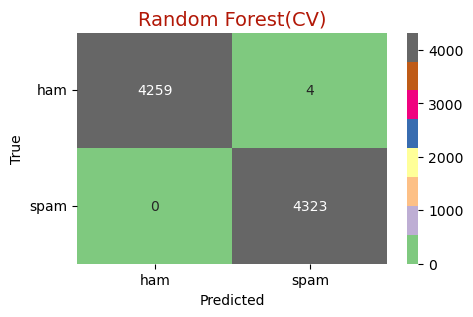

________________________________________________________________________
Classifcation Report for Random Forest

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Logistic Regression with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Logistic Regression(Unigram): 99.94%
------------------------------------------------------------------------


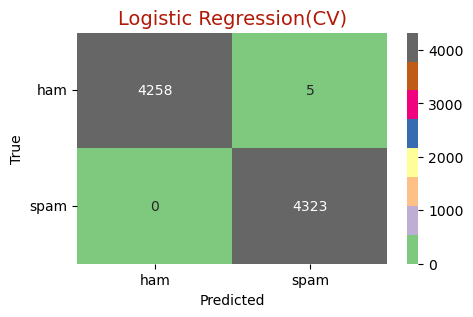

________________________________________________________________________
Classifcation Report for Logistic Regression

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Naive Bayes with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Naive Bayes(Unigram): 98.00999999999999%
------------------------------------------------------------------------


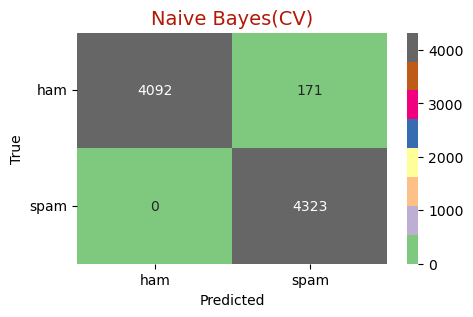

________________________________________________________________________
Classifcation Report for Naive Bayes

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      4263
        spam       0.96      1.00      0.98      4323

    accuracy                           0.98      8586
   macro avg       0.98      0.98      0.98      8586
weighted avg       0.98      0.98      0.98      8586

________________________________________________________________________
________________________________________________________________________
              K-Neighbors with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for K-Neighbors(Unigram): 99.92999999999999%
------------------------------------------------------------------------


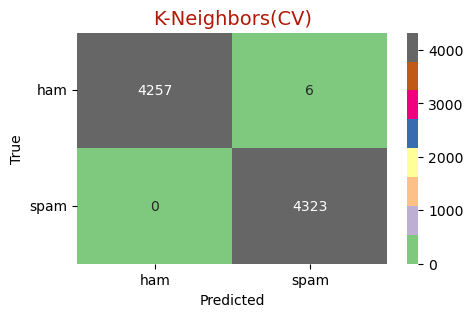

________________________________________________________________________
Classifcation Report for K-Neighbors

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Neural Network with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Neural Network(Unigram): 99.92999999999999%
------------------------------------------------------------------------


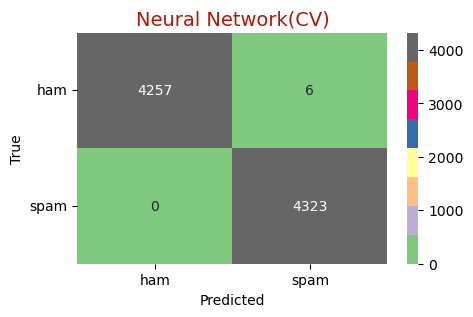

________________________________________________________________________
Classifcation Report for Neural Network

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Hybrid-Model with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Hybrid-Model(Unigram): 99.95%
------------------------------------------------------------------------


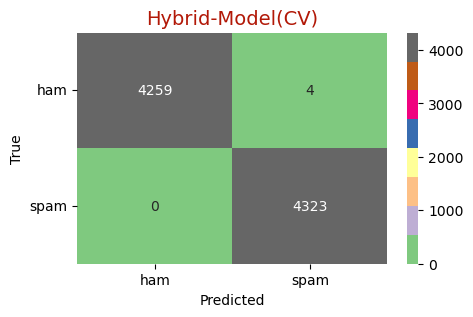

________________________________________________________________________
Classifcation Report for Hybrid-Model

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
         Count Vectorization with Bigram
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature Extracted Using CV and Bigram(Train): 560882
Feature Extracted Using CV and Bigram(Test): 560882
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
________________________________________________________________________
              Random Forest with Bigram
____________________________________

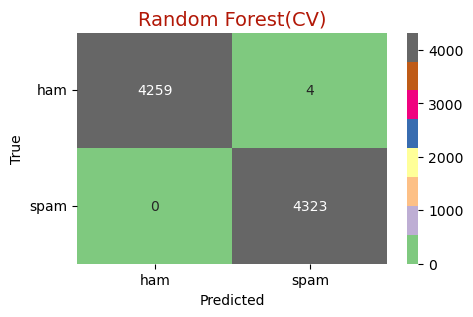

________________________________________________________________________
Classifcation Report for Random Forest

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Logistic Regression with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Logistic Regression(Bigram): 99.95%
------------------------------------------------------------------------


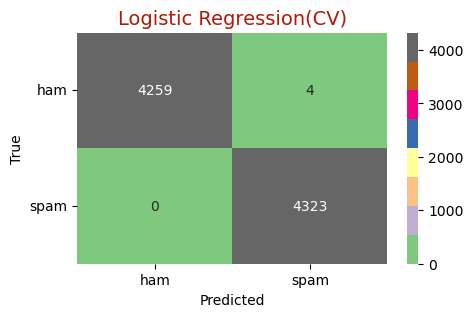

________________________________________________________________________
Classifcation Report for Logistic Regression

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Naive Bayes with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Naive Bayes(Bigram): 97.81%
------------------------------------------------------------------------


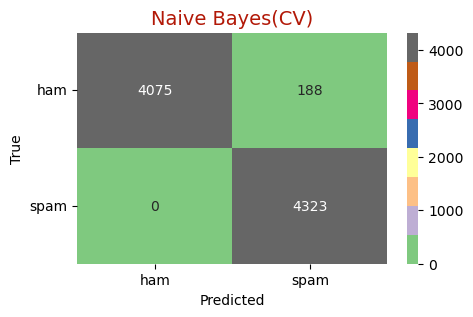

________________________________________________________________________
Classifcation Report for Naive Bayes

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      4263
        spam       0.96      1.00      0.98      4323

    accuracy                           0.98      8586
   macro avg       0.98      0.98      0.98      8586
weighted avg       0.98      0.98      0.98      8586

________________________________________________________________________
________________________________________________________________________
              K-Neighbors with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for K-Neighbors(Bigram): 99.94%
------------------------------------------------------------------------


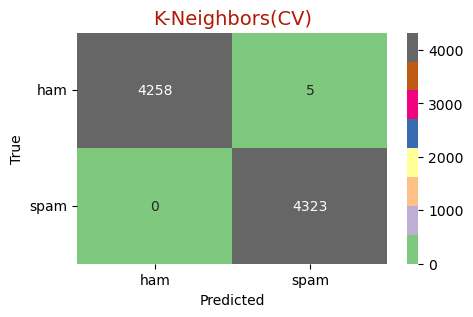

________________________________________________________________________
Classifcation Report for K-Neighbors

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Neural Network with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Neural Network(Bigram): 99.92%
------------------------------------------------------------------------


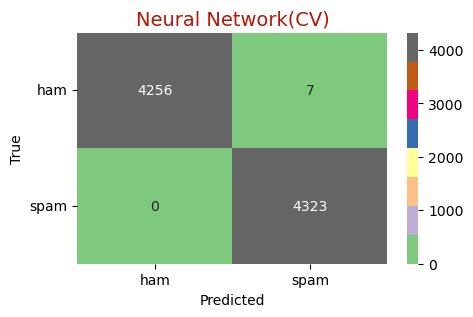

________________________________________________________________________
Classifcation Report for Neural Network

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Hybrid-Model with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Hybrid-Model(Bigram): 99.95%
------------------------------------------------------------------------


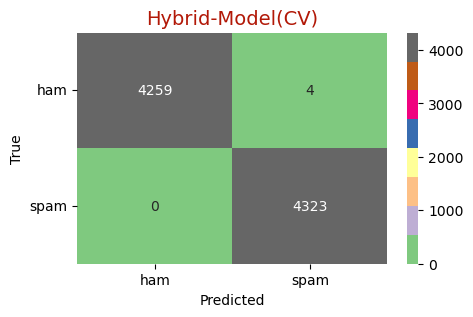

________________________________________________________________________
Classifcation Report for Hybrid-Model

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________


,Algorithm,Accuracy(Uni),Accuracy(Bi),Precision(Uni),Precision(Bi),Recall(Uni),Recall(Bi),F1-Score(Uni),F1-Score(Bi),Time(Uni),Time(Bi),Overfit(Uni),Overfit(Bi)
0,Random Forest,99.95,99.95,100.0,100.0,100.0,100.0,100.0,100.0,0.173,0.481,99.000466,99.000466
1,Logistic Regression,99.94,99.95,99.9,100.0,99.9,100.0,99.9,100.0,0.002,0.005,99.000582,99.000466
2,Naive Bayes,98.01,97.81,98.1,97.9,98.0,97.8,98.0,97.8,0.009,0.035,97.319916,97.221896
3,K-Neighbors,99.93,99.94,99.9,99.9,99.9,99.9,99.9,99.9,9.181,6.941,99.000699,99.000582
4,Neural Network,99.93,99.92,99.9,99.9,99.9,99.9,99.9,99.9,0.002,0.004,99.000699,99.000815
5,Hybrid-Model,99.95,99.95,100.0,100.0,100.0,100.0,100.0,100.0,0.219,0.526,99.000466,99.000466


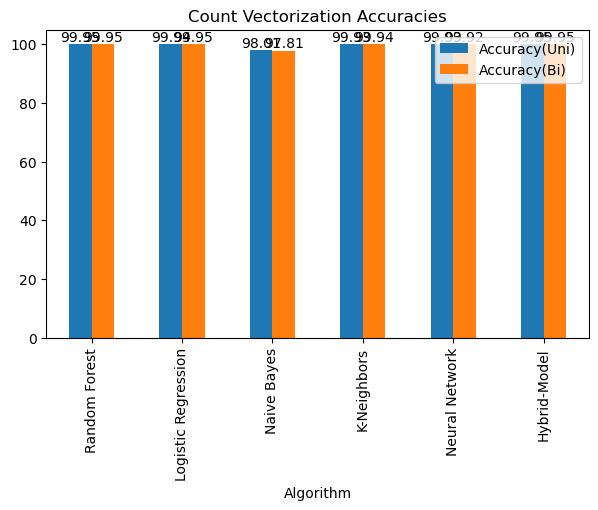

In [44]:
SpCvtResMets=[[[],[],[],[],[],[]],[[],[],[],[],[],[]]]
ValNg=["Unigram","Bigram"]
MetAv="weighted"

txt_SpDtTrPart=SpDtTrPart['Message']
txt_SpDtTsPart=SpDtTsPart['Message']
ClsTest=SpDtTsPart['Spam/Ham']
ClsTrain=SpDtTrPart['Spam/Ham']

for s in range(len(SpCvtResMets)):
    print("==============================================================")
    print("         Count Vectorization with {}".format(ValNg[s]))
    print("==============================================================")
    CVFet=CountVectorizer(stop_words='english', analyzer='word',max_df=0.6,ngram_range=(s+1,s+1))
    SpDtTrPartCVFet=CVFet.fit_transform(txt_SpDtTrPart) 
    SpDtTsPartCVFet=CVFet.transform(txt_SpDtTsPart)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Feature Extracted Using CV and {}(Train):".format(ValNg[s]),SpDtTrPartCVFet.shape[1])
    print("Feature Extracted Using CV and {}(Test):".format(ValNg[s]),SpDtTsPartCVFet.shape[1])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    vlrn=3
    print("________________________________________________________________________")
    for i in range(len(SpClfs)):
        print("              {} with {}".format(SpClfs[i],ValNg[s]))
        print("________________________________________________________________________")
        MdlCV = SpModels[i]
        MdlCV.fit(SpDtTrPartCVFet, ClsTrain)
        prd_tr=MdlCV.predict(SpDtTrPartCVFet)
        CVFetactr=round(metrics.accuracy_score(ClsTrain,prd_tr),vlrn)*100
        t1 = datetime.datetime.now()    
        prd_1=MdlCV.predict(SpDtTsPartCVFet)
        t2 = datetime.datetime.now()
        delta = t2 - t1
        ttm=delta.total_seconds()
        CVFetacts=metrics.accuracy_score(ClsTest,prd_1)
        Scr="%.4f" % CVFetacts
        TestCVAcr=eval(Scr)*100
        print("------------------------------------------------------------------------")
        print("     Model Accuracy for {}({}): {}%".format(SpClfs[i],ValNg[s],TestCVAcr))
        print("------------------------------------------------------------------------")
        SpCvtResMets[s][0].append(TestCVAcr)
        m2=metrics.precision_recall_fscore_support(ClsTest,prd_1, average=MetAv)[:-1]
        SpCvtResMets[s][1].append(round(m2[0],vlrn)*100)      
        SpCvtResMets[s][2].append(round(m2[1],vlrn)*100)
        SpCvtResMets[s][3].append(round(m2[2],vlrn)*100)
        cfMdlCV=pds.crosstab(ClsTest, prd_1, rownames=['True'], colnames=['Predicted'], margins=True)
        matsp.figure(figsize=(5,3))
        matsp.title("{}(CV)".format(SpClfs[i]),fontsize=14,color="#B21807")
        sbsp.heatmap(cfMdlCV.iloc[:2,:2],annot=True,cmap="Accent",fmt="d")
        matsp.yticks(rotation=0)
        matsp.show()
        print("________________________________________________________________________")
        print("Classifcation Report for {}\n".format(SpClfs[i]))
        print(metrics.classification_report(ClsTest, prd_1))
        print("________________________________________________________________________")
        print("________________________________________________________________________")
        ovCVFet=abs(CVFetactr-TestCVAcr)
        SpCvtResMets[s][4].append(round(ttm,3))
        SpCvtResMets[s][5].append(ovCVFet)
DF_CV=pds.DataFrame({
    "Algorithm":SpClfs,
    "Accuracy(Uni)":SpCvtResMets[0][0],
    "Accuracy(Bi)":SpCvtResMets[1][0],
    "Precision(Uni)":SpCvtResMets[0][1],
    "Precision(Bi)":SpCvtResMets[1][1],
    "Recall(Uni)":SpCvtResMets[0][2],
    "Recall(Bi)":SpCvtResMets[1][2],
    "F1-Score(Uni)":SpCvtResMets[0][3],
    "F1-Score(Bi)":SpCvtResMets[1][3],
    "Time(Uni)":SpCvtResMets[0][4],
    "Time(Bi)":SpCvtResMets[1][4],
    "Overfit(Uni)":SpCvtResMets[0][5],
    "Overfit(Bi)":SpCvtResMets[1][5]
})
DF_CV.to_csv("Result_for_CV.csv")


DF_CV1=DF_CV.iloc[:,:3].copy()
DF_CV1=DF_CV1.set_index("Algorithm")
ax=DF_CV1.plot(kind='bar',title="Count Vectorization Accuracies",figsize=(7,4))
for container in ax.containers:
    ax.bar_label(container)
DF_CV

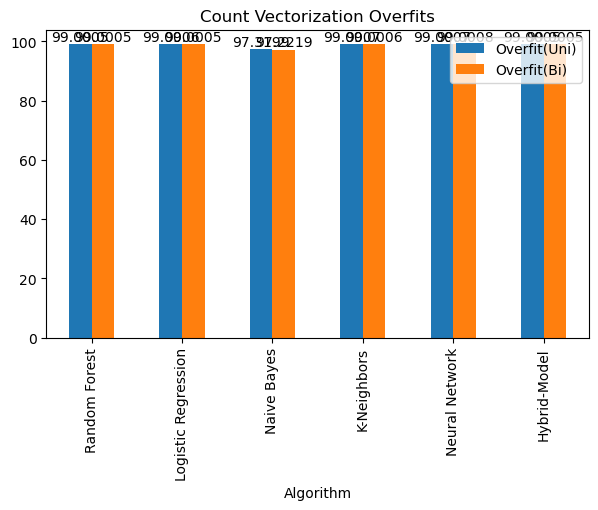

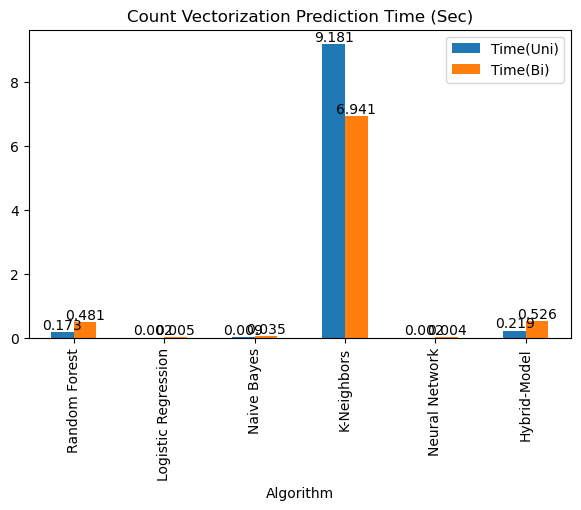

In [45]:
DF_CV1=DF_CV.iloc[:,[0,11,12]].copy()
DF_CV1=DF_CV1.set_index("Algorithm")
ax=DF_CV1.plot(kind='bar',title="Count Vectorization Overfits",figsize=(7,4))
for container in ax.containers:
    ax.bar_label(container)

DF_CV1=DF_CV.iloc[:,[0,9,10]].copy()
DF_CV1=DF_CV1.set_index("Algorithm")
ax=DF_CV1.plot(kind='bar',title="Count Vectorization Prediction Time (Sec)",figsize=(7,4))
for container in ax.containers:
    ax.bar_label(container)

         TFIDF with Unigram
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature Extracted Using TFIDF and Unigram(Train): 39285
Feature Extracted Using TFIDF and Unigram(Test): 39285
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
________________________________________________________________________
              Random Forest with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Random Forest(Unigram): 99.95%
------------------------------------------------------------------------


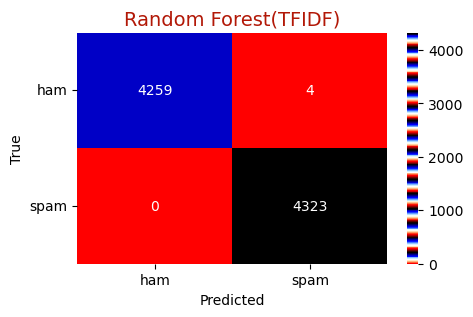

________________________________________________________________________
Classifcation Report for Random Forest

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Logistic Regression with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Logistic Regression(Unigram): 99.9%
------------------------------------------------------------------------


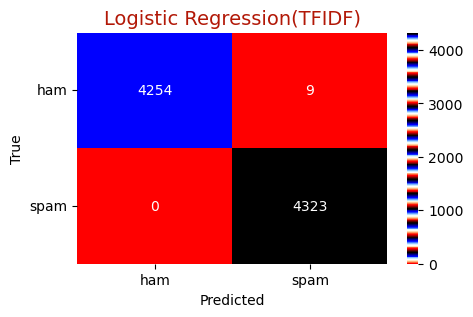

________________________________________________________________________
Classifcation Report for Logistic Regression

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Naive Bayes with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Naive Bayes(Unigram): 98.00999999999999%
------------------------------------------------------------------------


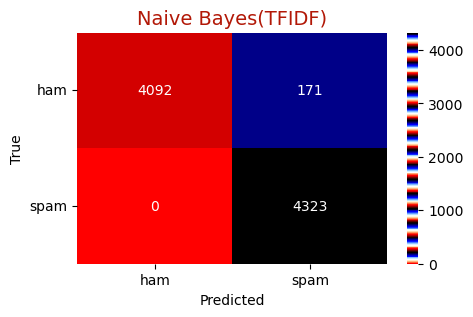

________________________________________________________________________
Classifcation Report for Naive Bayes

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      4263
        spam       0.96      1.00      0.98      4323

    accuracy                           0.98      8586
   macro avg       0.98      0.98      0.98      8586
weighted avg       0.98      0.98      0.98      8586

________________________________________________________________________
________________________________________________________________________
              K-Neighbors with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for K-Neighbors(Unigram): 99.94%
------------------------------------------------------------------------


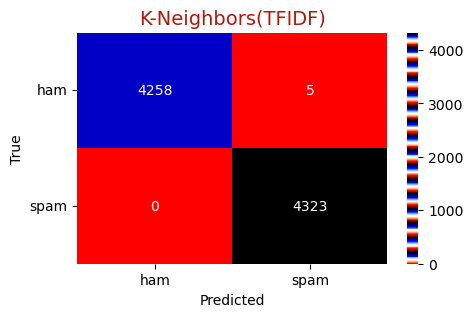

________________________________________________________________________
Classifcation Report for K-Neighbors

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Neural Network with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Neural Network(Unigram): 99.95%
------------------------------------------------------------------------


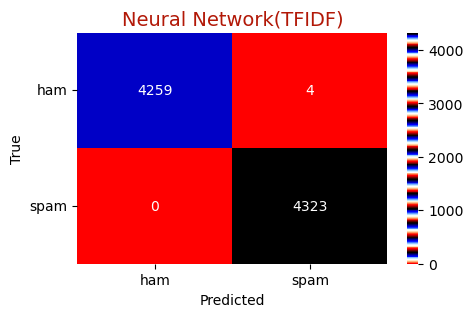

________________________________________________________________________
Classifcation Report for Neural Network

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Hybrid-Model with Unigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Hybrid-Model(Unigram): 99.95%
------------------------------------------------------------------------


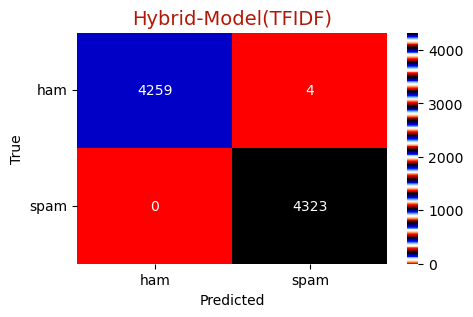

________________________________________________________________________
Classifcation Report for Hybrid-Model

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
         TFIDF with Bigram
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Feature Extracted Using TFIDF and Bigram(Train): 560882
Feature Extracted Using TFIDF and Bigram(Test): 560882
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
________________________________________________________________________
              Random Forest with Bigram
____________________________________________

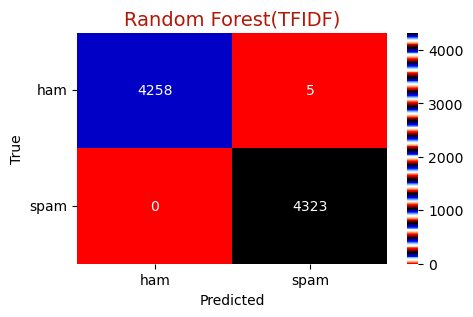

________________________________________________________________________
Classifcation Report for Random Forest

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Logistic Regression with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Logistic Regression(Bigram): 99.92999999999999%
------------------------------------------------------------------------


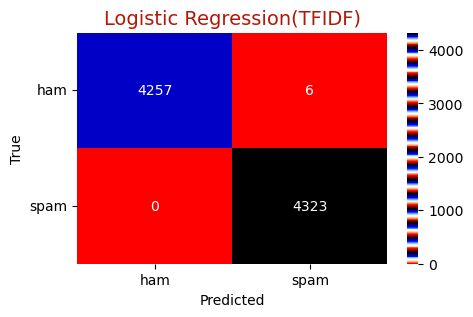

________________________________________________________________________
Classifcation Report for Logistic Regression

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Naive Bayes with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Naive Bayes(Bigram): 97.81%
------------------------------------------------------------------------


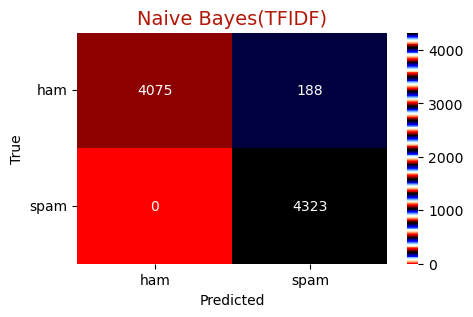

________________________________________________________________________
Classifcation Report for Naive Bayes

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      4263
        spam       0.96      1.00      0.98      4323

    accuracy                           0.98      8586
   macro avg       0.98      0.98      0.98      8586
weighted avg       0.98      0.98      0.98      8586

________________________________________________________________________
________________________________________________________________________
              K-Neighbors with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for K-Neighbors(Bigram): 99.94%
------------------------------------------------------------------------


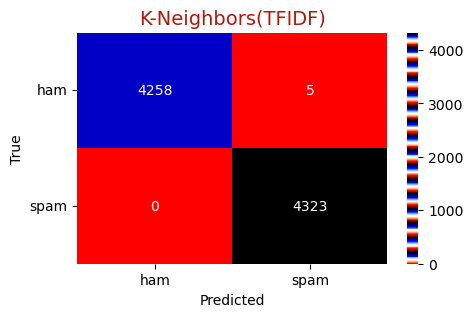

________________________________________________________________________
Classifcation Report for K-Neighbors

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Neural Network with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Neural Network(Bigram): 99.95%
------------------------------------------------------------------------


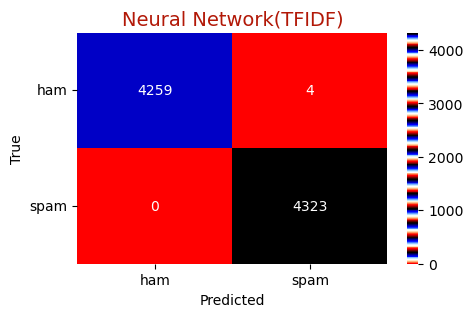

________________________________________________________________________
Classifcation Report for Neural Network

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________
              Hybrid-Model with Bigram
________________________________________________________________________
------------------------------------------------------------------------
     Model Accuracy for Hybrid-Model(Bigram): 99.95%
------------------------------------------------------------------------


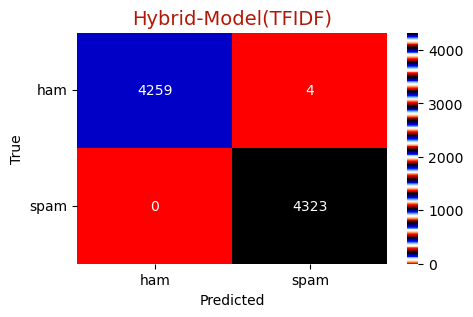

________________________________________________________________________
Classifcation Report for Hybrid-Model

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4263
        spam       1.00      1.00      1.00      4323

    accuracy                           1.00      8586
   macro avg       1.00      1.00      1.00      8586
weighted avg       1.00      1.00      1.00      8586

________________________________________________________________________
________________________________________________________________________


,Algorithm,Accuracy(Uni),Accuracy(Bi),Precision(Uni),Precision(Bi),Recall(Uni),Recall(Bi),F1-Score(Uni),F1-Score(Bi),Time(Uni),Time(Bi),Overfit(Uni),Overfit(Bi)
0,Random Forest,99.95,99.94,100.0,99.9,100.0,99.9,100.0,99.9,0.192,0.507,0.05,0.06
1,Logistic Regression,99.90,99.93,99.9,99.9,99.9,99.9,99.9,99.9,0.002,0.004,0.00,0.03
2,Naive Bayes,98.01,97.81,98.1,97.9,98.0,97.8,98.0,97.8,0.009,0.032,0.29,0.39
3,K-Neighbors,99.94,99.94,99.9,99.9,99.9,99.9,99.9,99.9,90.026,164.097,0.06,0.06
4,Neural Network,99.95,99.95,100.0,100.0,100.0,100.0,100.0,100.0,0.001,0.004,0.05,0.05
5,Hybrid-Model,99.95,99.95,100.0,100.0,100.0,100.0,100.0,100.0,0.229,0.609,0.05,0.05


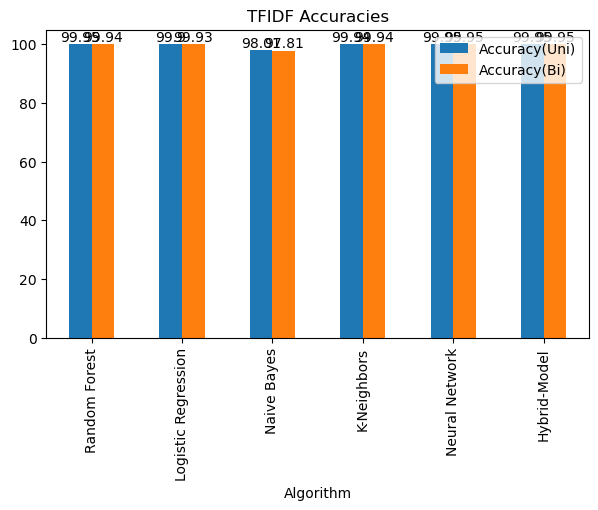

In [48]:
ValNg=["Unigram","Bigram"]
MetAv="weighted"

txt_SpDtTrPart=SpDtTrPart['Message']
txt_SpDtTsPart=SpDtTsPart['Message']
ClsTest=SpDtTsPart['Spam/Ham']
ClsTrain=SpDtTrPart['Spam/Ham']

SpTFtResMets=[[[],[],[],[],[],[]],[[],[],[],[],[],[]]]
for s in range(len(SpTFtResMets)):
    print("==============================================================")
    print("         TFIDF with {}".format(ValNg[s]))
    print("==============================================================")
    TFFet=TfidfVectorizer(stop_words='english', analyzer='word',max_df=0.6,ngram_range=(s+1,s+1))
    SpDtTrPartTFFet=TFFet.fit_transform(txt_SpDtTrPart) 
    SpDtTsPartTFFet=TFFet.transform(txt_SpDtTsPart)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Feature Extracted Using TFIDF and {}(Train):".format(ValNg[s]),SpDtTrPartTFFet.shape[1])
    print("Feature Extracted Using TFIDF and {}(Test):".format(ValNg[s]),SpDtTsPartTFFet.shape[1])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    vlrn=3
    print("________________________________________________________________________")
    for i in range(len(SpClfs)):
        print("              {} with {}".format(SpClfs[i],ValNg[s]))
        print("________________________________________________________________________")
        MdlTF = SpModels[i]
        MdlTF.fit(SpDtTrPartTFFet, ClsTrain)
        prd_tr=MdlTF.predict(SpDtTrPartTFFet)
        TFFetactr=round(metrics.accuracy_score(ClsTrain,prd_tr),vlrn)*100
        t1 = datetime.datetime.now()    
        prd_2=MdlTF.predict(SpDtTsPartTFFet)
        t2 = datetime.datetime.now()
        delta = t2 - t1
        ttm=delta.total_seconds()
        TFFetacts=metrics.accuracy_score(ClsTest,prd_2)
        Scr="%.4f" % TFFetacts
        TestTFAcr=eval(Scr)*100
        print("------------------------------------------------------------------------")
        print("     Model Accuracy for {}({}): {}%".format(SpClfs[i],ValNg[s],TestTFAcr))
        print("------------------------------------------------------------------------")
        SpTFtResMets[s][0].append(TestTFAcr)
        m2=metrics.precision_recall_fscore_support(ClsTest,prd_2, average=MetAv)[:-1]
        SpTFtResMets[s][1].append(round(m2[0],vlrn)*100)      
        SpTFtResMets[s][2].append(round(m2[1],vlrn)*100)
        SpTFtResMets[s][3].append(round(m2[2],vlrn)*100)
        cfMdlTF=pds.crosstab(ClsTest, prd_2, rownames=['True'], colnames=['Predicted'], margins=True)
        matsp.figure(figsize=(5,3))
        matsp.title("{}(TFIDF)".format(SpClfs[i]),fontsize=14,color="#B21807")
        sbsp.heatmap(cfMdlTF.iloc[:2,:2],annot=True,cmap="flag",fmt="d")
        matsp.yticks(rotation=0)
        matsp.show()
        print("________________________________________________________________________")
        print("Classifcation Report for {}\n".format(SpClfs[i]))
        print(metrics.classification_report(ClsTest, prd_2))
        print("________________________________________________________________________")
        print("________________________________________________________________________")
        ovTFFet=abs(TFFetactr-TestTFAcr)
        SpTFtResMets[s][4].append(round(ttm,3))
        SpTFtResMets[s][5].append(ovTFFet)
DF_TF=pds.DataFrame({
    "Algorithm":SpClfs,
    "Accuracy(Uni)":SpTFtResMets[0][0],
    "Accuracy(Bi)":SpTFtResMets[1][0],
    "Precision(Uni)":SpTFtResMets[0][1],
    "Precision(Bi)":SpTFtResMets[1][1],
    "Recall(Uni)":SpTFtResMets[0][2],
    "Recall(Bi)":SpTFtResMets[1][2],
    "F1-Score(Uni)":SpTFtResMets[0][3],
    "F1-Score(Bi)":SpTFtResMets[1][3],
    "Time(Uni)":SpTFtResMets[0][4],
    "Time(Bi)":SpTFtResMets[1][4],
    "Overfit(Uni)":SpTFtResMets[0][5],
    "Overfit(Bi)":SpTFtResMets[1][5]
})
DF_TF.to_csv("Result_for_TFIDF.csv")


DF_TF1=DF_TF.iloc[:,:3].copy()
DF_TF1=DF_TF1.set_index("Algorithm")
ax=DF_TF1.plot(kind='bar',title="TFIDF Accuracies",figsize=(7,4))
for container in ax.containers:
    ax.bar_label(container)

DF_TF

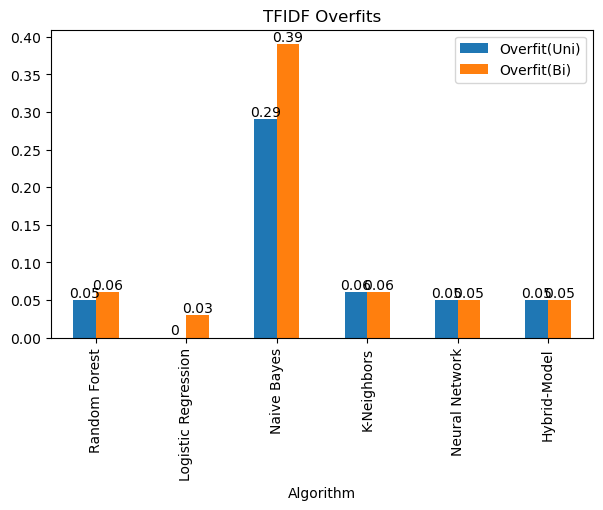

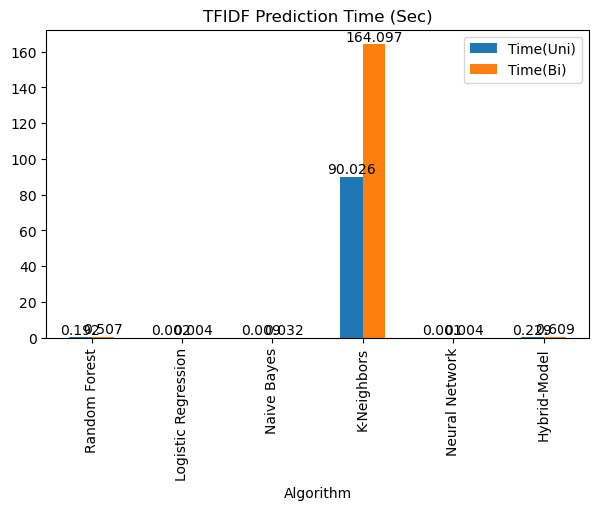

In [49]:
DF_TF1=DF_TF.iloc[:,[0,11,12]].copy()
DF_TF1=DF_TF1.set_index("Algorithm")
ax=DF_TF1.plot(kind='bar',title="TFIDF Overfits",figsize=(7,4))
for container in ax.containers:
    ax.bar_label(container)

DF_TF1=DF_TF.iloc[:,[0,9,10]].copy()
DF_TF1=DF_TF1.set_index("Algorithm")
ax=DF_TF1.plot(kind='bar',title="TFIDF Prediction Time (Sec)",figsize=(7,4))
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
pickle.load(open('LR.sav', 'rb'))

In [ ]:
CountVectorizer(stop_words='english', analyzer='word',max_df=0.6,ngram_range=(1,1))

In [2]:
tune_hyp_prm=[
        [{'criterion': ['gini', 'entropy'],'max_depth':[90,100]}],
        [{"tol":[0.01,0.001,0.0001,0.00001],'C':[0.2,0.4,0.6,0.8,1.0],"max_iter":[100,200]}],
        [{"alpha":[0.2,0.4,0.6,0.8,1.0]}],
        [{"n_neighbors":[4,5,6],"algorithm":['auto','kd_tree']}],
        [{"max_iter":[500,1000],"alpha":[0.0001,0.00001,0.000001],"tol":[0.001,0.0001,0.00001]}]
    ]
print(*tune_hyp_prm, sep="\n")

[{'criterion': ['gini', 'entropy'], 'max_depth': [90, 100]}]
[{'tol': [0.01, 0.001, 0.0001, 1e-05], 'C': [0.2, 0.4, 0.6, 0.8, 1.0], 'max_iter': [100, 200]}]
[{'alpha': [0.2, 0.4, 0.6, 0.8, 1.0]}]
[{'n_neighbors': [4, 5, 6], 'algorithm': ['auto', 'kd_tree']}]
[{'max_iter': [500, 1000], 'alpha': [0.0001, 1e-05, 1e-06], 'tol': [0.001, 0.0001, 1e-05]}]
